In [3]:
import numpy as np
from PIL import Image
import torch
import classification_nbv as cnbv
import rescalado as res

In [33]:
def linear_interpolation(x,p1,p2):
    y = (p1[2] * (p2[1] - x) + p2[2] * (x - p1[1])) / (p2[1] - p1[1])
    return y

In [34]:
x = 14.5
x0 = np.asarray([0,14,95])
x1 = np.asarray([0,15,162])

y = linear_interpolation(x,x0,x1)
y

128.5

In [94]:
#Row y luego column
def bilinear_interpolation(x,p1,p2,p3,p4):
    y1 = linear_interpolation(x[0], p1, p3)
    y2 = linear_interpolation(x[0], p2, p4)
    #print(y1,y2)
    y = ((p2[0] - x[1] )/ (p2[0] - p1[0])) * y1 + ((x[1] - p1[0]) / (p2[0] - p1[0])) * y2
    return y  

In [111]:
x = np.asarray([0.25,0.75])
x0 = np.asarray([0,0,1])
x1 = np.asarray([1,0,0])
x2 = np.asarray([0,1,0.5])
x3 = np.asarray([1,1,1])
y = bilinear_interpolation(x,x0,x1,x2,x3)
y

0.40625

In [103]:
x = np.asarray([14.5,20.2])
x0 = np.asarray([20,14,91])
x1 = np.asarray([21,14,162])
x2 = np.asarray([20,15,210])
x3 = np.asarray([21,15,95])
y = bilinear_interpolation(x,x0,x1,x2,x3)
y

146.10000000000002

In [112]:
nx = 200
ny = 100
channels = 3
print("P3\n{} {} \n255\n".format(nx,ny))
z = np.zeros((nx,ny, channels), dtype='B')
for j in range(ny-1,-1,-1):
  n_y = (j-0)/(ny-0)
  for i in range (0, nx):
    n_x = (i-0.5)/(nx-0.5)
    x = np.asarray([n_x,n_y])
    y = bilinear_interpolation(x,x0,x1,x2,x3)
    z[i,j,0] = int(255.99*y)
    z[i,j,1] = int(255.99*y)
    z[i,j,2] = int(255.99*y)

P3
200 100 
255



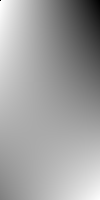

In [113]:
img = Image.fromarray(np.uint8(z), mode='RGB')
img.show()

In [106]:
ppm_header = f'P6 {nx} {ny} {255}\n'
with open('ppm_1.ppm', 'w') as f: #'wb'
  f.write(ppm_header)#bytearray(ppm_header, 'ascii'))
  z.tofile(f)

# Trilienar interpolation

In [2]:
import numpy as np
from PIL import Image
import torch
import classification_nbv as cnbv
import matplotlib.pyplot as plt

In [3]:
obj = np.load('MODELDATASET/completo_val/2_capilla.npy')
obj.shape

(32, 32, 32)

<Figure size 432x288 with 0 Axes>

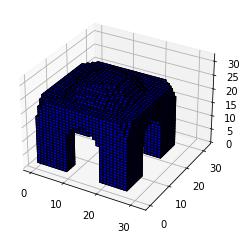

In [3]:
cnbv.showGrid(obj)

### Proceso de interpolación

1. Seleccion del punto a interpolar
2. Selección de vecinos arriba y abajo 
    Si queremos interpolar un punto por decir (0.5,0.5,0.5) tomaremos los vecinos de arriba y abajo, 0 y 1 que crearán las combinaciones posibles de 3 elementos de (0,0,0),...,(1,1,1)
3. Conocidos los vecinos, vamos a tomar los valores de intensidad de cada uno de ellos
4. Vamos a interpolar trilinearmente!
5. Repite

In [4]:
BOX_OFFSETS1 = np.asarray([[[i,j,k] for i in np.linspace(0,30,31) for j in np.linspace(0,30,31) for k in np.linspace(0,30,31)]])
Desired = np.asarray([31,31,31]) #Tamaño deseado
Original = np.asarray([32,32,32]) #Tamaño original
bounding_box = np.asarray([0,0,0]), np.asarray([30,30,30])
min_vertex, max_vertex = res.get_vertex(BOX_OFFSETS1, bounding_box)
resized = res.voxel_resizing(BOX_OFFSETS1, Original, Desired)
values = res.neighbor_vertex(max_vertex, obj)

NameError: name 'obj' is not defined

In [5]:
resized

array([[[ 0.     ,  0.     ,  0.     ],
        [ 0.     ,  0.     ,  0.96875],
        [ 0.     ,  0.     ,  1.9375 ],
        ...,
        [29.0625 , 29.0625 , 27.125  ],
        [29.0625 , 29.0625 , 28.09375],
        [29.0625 , 29.0625 , 29.0625 ]]])

In [8]:
min_vertex

array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  2.],
        ...,
        [30., 30., 28.],
        [30., 30., 29.],
        [30., 30., 30.]]])

In [7]:
max_vertex

array([[[ 1.,  1.,  1.],
        [ 1.,  1.,  2.],
        [ 1.,  1.,  3.],
        ...,
        [31., 31., 29.],
        [31., 31., 30.],
        [31., 31., 31.]]])

In [6]:
np.ceil(resized)

array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  1.],
        [ 0.,  0.,  2.],
        ...,
        [30., 30., 28.],
        [30., 30., 29.],
        [30., 30., 30.]]])

In [6]:
new_obj = res.trilinear_interpolation(resized,min_vertex,max_vertex, values)

In [7]:
new_obj = np.reshape(new_obj, [31,31,31])

<Figure size 432x288 with 0 Axes>

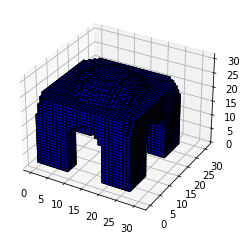

In [8]:
cnbv.showGrid(new_obj)

In [9]:
BOX_OFFSETS1 = np.asarray([[[i,j,k] for i in np.linspace(0,30,31) for j in np.linspace(0,30,31) for k in np.linspace(0,30,31)]])
Desired = np.asarray([31,31,31]) #Tamaño deseado
Original = np.asarray([32,32,32]) #Tamaño original
bounding_box = np.asarray([0,0,0]), np.asarray([30,30,30])
min_vertex, max_vertex = res.get_vertex(BOX_OFFSETS1, bounding_box)
resized = res.voxel_resizing(BOX_OFFSETS1, Original, Desired)
# Modificar los inidices del reshape, para no estar condicionado al numero de datos
train = np.reshape(np.load('archive/training/dataset_vol_training.npy'), [12132,32,32,32]) #Objetos entrenamiento
validation = np.reshape(np.load('archive/validation/dataset_vol_validation.npy'), [3034,32,32,32]) #Objetos validación
new_obj_train = np.zeros([len(train),len(max_vertex[0,])])
new_obj_validation = np.zeros([len(validation),len(max_vertex[0,])])
#PRoceso por objeto
for i in range (0,len(train)):
    values = res.neighbor_vertex(max_vertex, train[i])
    new_obj_train[i] = res.trilinear_interpolation(resized,min_vertex,max_vertex, values)

for i in range (0,len(validation)):
    values = res.neighbor_vertex(max_vertex, validation[i])
    new_obj_validation[i] = res.trilinear_interpolation(resized,min_vertex,max_vertex, values)

np.save('dataset_vol_training_resized.npy', new_obj_train)
np.save('dataset_vol_validation_resized.npy', new_obj_validation)

<Figure size 432x288 with 0 Axes>

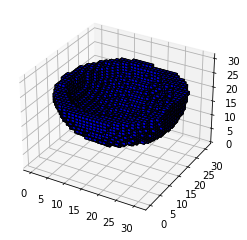

<Figure size 432x288 with 0 Axes>

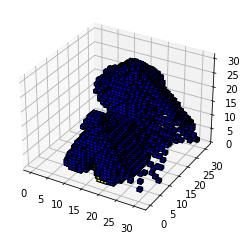

<Figure size 432x288 with 0 Axes>

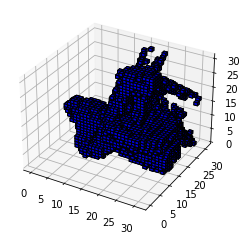

<Figure size 432x288 with 0 Axes>

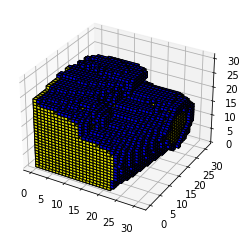

In [17]:
cnbv.showGrid(np.reshape(new_obj_train[0], [31,31,31]))
cnbv.showGrid(np.reshape(new_obj_train[1], [31,31,31]))
cnbv.showGrid(np.reshape(new_obj_train[2], [31,31,31]))
cnbv.showGrid(np.reshape(new_obj_train[3], [31,31,31]))

<Figure size 432x288 with 0 Axes>

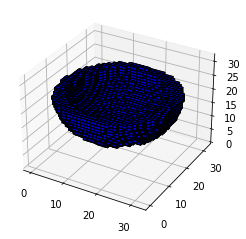

<Figure size 432x288 with 0 Axes>

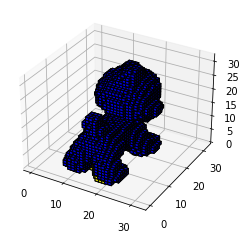

<Figure size 432x288 with 0 Axes>

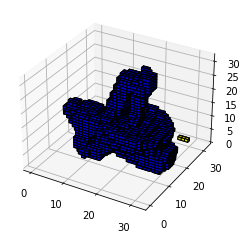

<Figure size 432x288 with 0 Axes>

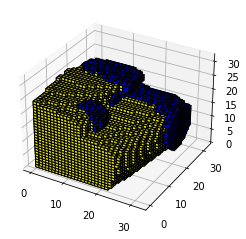

In [16]:
cnbv.showGrid(train[0])
cnbv.showGrid(train[1])
cnbv.showGrid(train[2])
cnbv.showGrid(train[3])

In [48]:
#PARa interpolacion trilinear requiere que los datos esten en 5D mini-batch x channels x d x h x w
tensor = torch.tensor([validation])
new_tensor = torch.nn.functional.interpolate(tensor, scale_factor=(0.96875), mode='trilinear')

In [49]:
new = new_tensor[0].numpy()
new = new.reshape(3034,29791)

<Figure size 432x288 with 0 Axes>

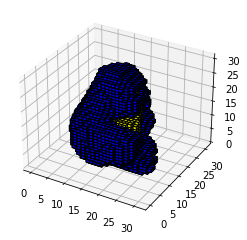

In [54]:
cnbv.showGrid(new[10].reshape(31,31,31))

<Figure size 432x288 with 0 Axes>

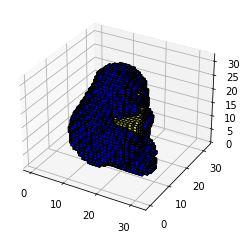

In [55]:
cnbv.showGrid(validation[10])

In [51]:
new.shape

(3034, 29791)

In [52]:
np.save('dataset_vol_validation_resized_pytorch.npy', new)